Traders borrow money in the low-interest-rate currency. They can do this by either taking out a loan or using leverage provided by a broker. The borrowed funds are used to invest in assets denominated in a high-interest-rate currency. The goal of carry trading is to profit from the interest rate differential between the two currencies aka **swap or rollover fee**

Monitor economic factors, central bank policies, and market conditions to determine the optimal time to enter and exit trades.

# Import libraries

In [1]:
import pandas as pd
import pandas_ta as ta
import pandas_datareader as pdr
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

AUD/JPY or NZD/JPY

In [2]:
# Retrieve long-term interest rate data for Japan from the Federal Reserve Economic Data (FRED) database
japan_ir = pdr.DataReader('IRLTLT01JPM156N', 'fred', start='1998-01-01')
# 10-year Treasury note closing yield price for each month
usa_ir = yf.download('^TNX', start='1998-01-01')['Close'].resample('M').last().to_frame()[:-3]
japan_ir = japan_ir.set_index(usa_ir.index)

[*********************100%%**********************]  1 of 1 completed


In [3]:
irdata = usa_ir.merge(japan_ir, left_index=True, right_index=True, how='left', suffixes=('_spy', '_inflation'))
irdata = irdata.rename(columns = {'Close': '10yUSA', 'IRLTLT01JPM156N': '10yJapan'})
irdata['10yJapan'] = irdata['10yJapan']/100/12
irdata['10yUSA'] = irdata['10yUSA']/100/12

In [4]:
data = pd.DataFrame()
data['USDJPY'] = yf.download('JPY=X', start='1998-01-01')['Close'].resample('M').last().to_frame()[:-3]
data['Change'] = data['USDJPY'].pct_change() + 1

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Fetch historical data for US Dollar Index
data['DXY'] = yf.download('DX-Y.NYB', start='1998-01-01')['Close'].resample('M').last().to_frame()[:-3]
data['DXY_SMA'] = ta.sma(data['DXY'], length=10)
# data['dxi'].rolling(window=10).mean()

[*********************100%%**********************]  1 of 1 completed


In [6]:
data['SpotDifference'] = data['USDJPY'] / data['USDJPY'].shift(1)
data['Return'] = (1 + (irdata['10yUSA'] - irdata['10yJapan'])) * data['SpotDifference']

In [7]:
data['Return/wFilter'] = 1.00
for i in range(1, len(data)):
    if data['DXY'][i-1] >= data['DXY_SMA'][i-1]:
        data['Return/wFilter'][i] = (1 + (irdata['10yUSA'][i] - irdata['10yJapan'][i])) * data['SpotDifference'][i]

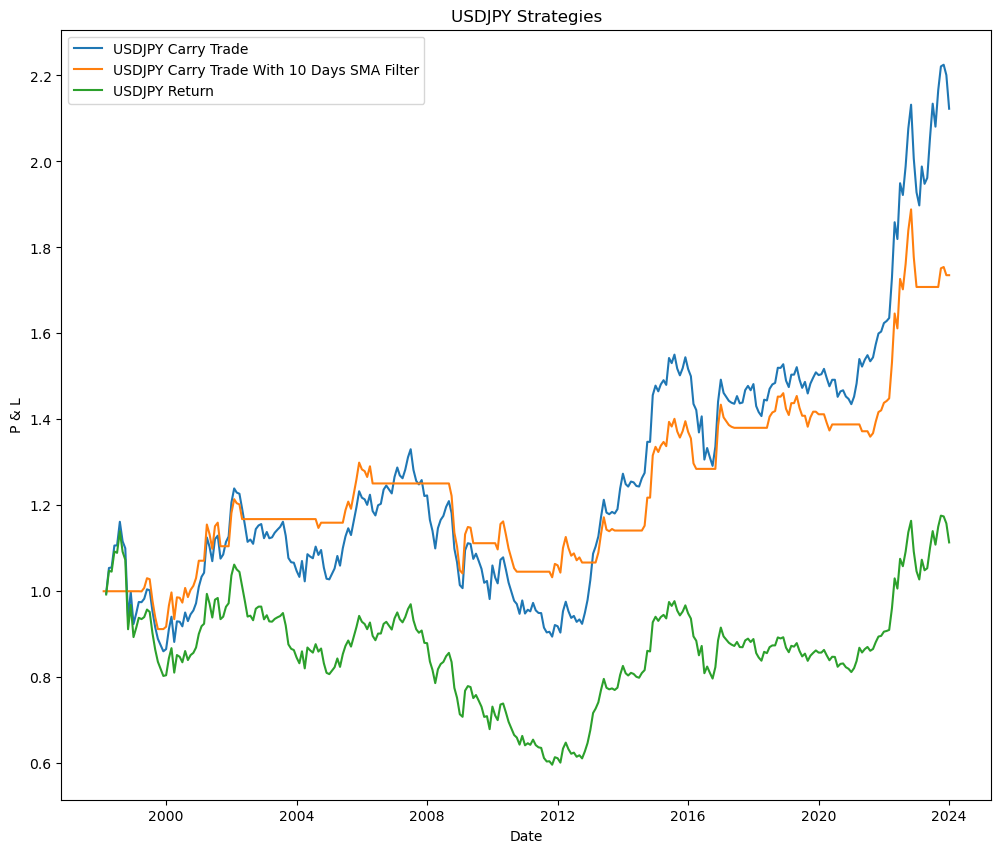

In [8]:
plt.figure(figsize=(12,10))

plt.plot(data['Return'].cumprod(), label = 'USDJPY Carry Trade')
plt.plot(data['Return/wFilter'].cumprod(), label = 'USDJPY Carry Trade With 10 Days SMA Filter')
plt.plot(data['Change'].cumprod(), label = 'USDJPY Return')

plt.title('USDJPY Strategies')
plt.xlabel('Date')
plt.ylabel('P & L')
# plt.yscale('log')
plt.legend()
plt.show()